**Exercice** The objective of this exercice is to develop a pose estimation and cude perspective projection in video, based on the "pose estimation" section presented in TP5. 
As input, you have a file video of "louvre" [view](https://github.com/kinect59/3DET20/blob/master/Data/vid.mp4) and a [photo](https://github.com/kinect59/3DET20/blob/master/Data/louvre.jpg) of the scene.
The requested output is a video where a pose estimation of the camera is represen whithin a cube perspective projection like this [output video](https://github.com/kinect59/3DET20/blob/master/Data/output_cube_pose_video1.mp4)

Exercices completed by **Sebastien Maes** - FI21/INGE3 - 2020/2021

Install OpenCV 3.4.2

In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Here, you find the calibration data of the camera used to capture the video

In [ ]:
import cv2
import numpy as np

is_downsample = False
is_cube = True

# Camera Matrix and distorsion coefficients
K = np.array([[1.53653164e+03, 0.00000000e+00, 1.04318348e+03],
              [0.00000000e+00, 1.54022929e+03, 5.67584058e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist_coeffs = np.array([0.2897652,  -2.45780323, 0.01189844, 0.02099917, 6.97784126])

# image size in cm
REF_IM_W = 28
REF_IM_H = 19

**Idea of the solution:**


1.   detect sift keypoint from reference image ('louvre.png')
2.   for each frames of the video: 
*   detect sift keypoint 
*   match keypoints between the reference and frame image
*   find homography matrix to warp the image
*   apply pose estimation and cude drwing



**ATTEMPT WITH HOMOGRAPHY-BASED POSE ESTIMATION** (Works partially)

Tested with FlaNN Matcher and Brute Force Matcher

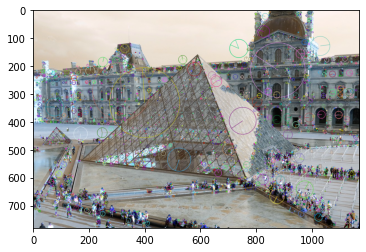

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# === extract feature from ref image ===
ref_im = cv2.imread("louvre.jpg")
ref_im_gray = cv2.cvtColor(ref_im, cv2.COLOR_BGR2GRAY)

#IMAGE_SIZE = (780, 1170) # in pixels
#objp = np.zeros((REF_IM_H*REF_IM_W, 3), np.float32)
#objp[:,:2] = np.mgrid[0:REF_IM_W,0:REF_IM_H].T.reshape(-1,2)
#objp[:, :2] = np.indices(IMAGE_SIZE).T.reshape(-1, 2)


# FEATURE EXTRACTOR (SIFT)
sift = cv2.xfeatures2d.SIFT_create(nfeatures=5000)

# Detect and compute keypoints
kp_ref, desc_ref = sift.detectAndCompute(ref_im, None) # Pixel coordinates (image)

# Ref Keypoints with Metric coordinates in cm (object)
kp_ref_XY = [[x.pt[0]/ref_im_gray.shape[1]*REF_IM_W,
              x.pt[1]/ref_im_gray.shape[0]*REF_IM_H,0] for x in kp_ref]

# Display keypoints
kp_view = cv2.drawKeypoints(ref_im, kp_ref, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(kp_view)
plt.show()


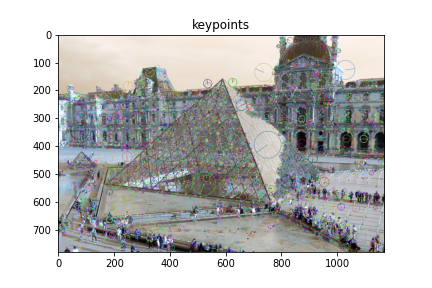

Read the video in opencv:

HOMOGRAPHY-BASED POSE ESTIMATION WITH FLANN MATCHER

In [ ]:
# WITH HOMOGRAPHY (FlaNN Matcher)
is_downsample = False
is_cube = True
# ===== video input
cap = cv2.VideoCapture('vid.mp4')
fps = np.round(cap.get(cv2.CAP_PROP_FPS))
width = int(np.round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
height = int(np.round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# ==== video write
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

# ================= Cube draw function
# Cube vertices coordinates (3D)
objectPoints = 5 * np.float32([[0,0,0], [0,1,0], [1,1,0], [1,0,0],[0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]]).reshape(-1,3)
def draw(img, imgpts, rvec, tvec, H):
    # Render model in the middle of the reference surface. To do so,
    # model points must be displaced
    points = np.array([[p[0] + REF_IM_W / 2, p[1] + REF_IM_H / 2, p[2]] for p in objectPoints])

    # Project 3D points (world) to 2D points (frame)
    imgpts = cv2.projectPoints(points.reshape(-1, 1, 3), rvec, tvec, K, dist_coeffs)[0]
    #imgpts = cv2.perspectiveTransform(imgpts, H)
    imgpts = np.int32(imgpts).reshape(-1,2)

    # Draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-1)

    # Draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img
# ========== run on all frames
frame_num = -1
while True:
    # Read Frame
    flag, frame = cap.read()
    if not flag:
        break

    frame_num += 1
    print("frame num " + str(frame_num))

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # display the video frames
    plt.imshow(frame)
    plt.show()

    # Find the keypoints and descriptors with chosen feature_extractor
    kp_frame, desc_frame = sift.detectAndCompute(frame, None)


    # Feature Matching
    # FLANN Parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(desc_ref,desc_frame,k=2)
   
    good_matches = []
    good_kp_ref = []
    good_kp_ref_XY = []
    good_kp_frame = []
    
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.5*n.distance:
            good_matches.append(m)
            good_kp_ref.append(kp_ref[m.queryIdx].pt) # ref image points (pixel coordinates)
            good_kp_ref_XY.append([kp_ref_XY[m.queryIdx][0], kp_ref_XY[m.queryIdx][1], 0]) # ref object points (metric)
            good_kp_frame.append(kp_frame[m.trainIdx].pt) # Scene points
            
    good_kp_ref = np.int32(good_kp_ref)
    good_kp_frame = np.int32(good_kp_frame)

    match_img = cv2.drawMatches(ref_im, kp_ref, frame, kp_frame, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    plt.title("Matches")
    plt.imshow(match_img)
    plt.show()

    # Homography
    H, masked = cv2.findHomography(good_kp_ref, good_kp_frame, cv2.RANSAC, 5.0)

    # 2nd filtering : Keep only inliers (masked)
    where = np.where(masked.ravel() == 1)[0]
    best_kp_ref = np.float32(good_kp_ref[where]) # ref (pixel)

    best_kp_ref_XY = np.float32(good_kp_ref_XY)
    best_kp_ref_XY = np.take(best_kp_ref_XY, where, axis=0) # ref (metric)

    best_kp_frame = good_kp_frame[where] # frame (pixel)

    # Draw Reference Outline
    ref_im_height = ref_im.shape[0]
    ref_im_width = ref_im.shape[1]
    object_pts = np.float32([ [0,0],[0,ref_im_height-1],[ref_im_width-1,ref_im_height-1],[ref_im_width-1,0] ]).reshape(-1,1,2)
    objectOutline = cv2.perspectiveTransform(object_pts, H)
    objectOutline_img = cv2.polylines(frame_rgb,[np.int32(objectOutline)],True,(255,0,0),6, cv2.LINE_AA)

    plt.title("Outline (with perspective transform)")
    plt.imshow(objectOutline_img)
    plt.show()

    # Warp
    #warped = cv2.warpPerspective(frame, H, (frame_rgb.shape[1],frame_rgb.shape[0]))
    #warped = warpTwoImages(frame, im_ref, H)
    #plt.title("Warped")
    #plt.imshow(warped)
    #plt.show()
        
    # ========= solve PnP to get camera pose
    found, rvec, tvec = cv2.solvePnP(best_kp_ref_XY, best_kp_ref, K, dist_coeffs)
    rotM = cv2.Rodrigues(rvec)[0]
    cameraPosition = -np.float32(rotM).T * np.float32(tvec)
    
    # ======== draw projection result
    drawn_image = draw(frame, imgpts, rvec, tvec, H)


    # =========== output
    final_res = cv2.cvtColor(drawn_image, cv2.COLOR_RGB2BGR)
    plt.title("Final Result")
    plt.imshow(final_res)
    plt.show() 
    
    out.write(final_res)


# ======== end all



HOMOGRAPHY-BASED POSE ESTIMATION WITH BRUTE FORCE MATCHER

In [ ]:
# WITH HOMOGRAPHY (BFMATCHER)
is_downsample = False
is_cube = True
# ===== video input
cap = cv2.VideoCapture('vid.mp4')
fps = np.round(cap.get(cv2.CAP_PROP_FPS))
width = int(np.round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
height = int(np.round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# ==== video write
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

# Minimum number of matches that have to be found
# to consider the recognition valid
MIN_MATCHES = 10

# ================= Cube draw function
# Cube vertices coordinates (3D)
ratio = REF_IM_W / REF_IM_H
objectPoints = 5 * ratio * np.array([[0,0,0], [0,1,0], [1,1,0], [1,0,0],[0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]],dtype=float)
def draw(img, imgpts, rvec, tvec, H):
    # Render cube in the middle of the reference surface. To do so,
    # cube vertices must be displaced
    points = np.array([[p[0] + REF_IM_W / 2, p[1] + REF_IM_H / 2, p[2]] for p in objectPoints])

    # Project 3D points (world) to 2D points (frame)
    imgpts = cv2.projectPoints(points.reshape(-1, 1, 3), rvec, tvec, K, dist_coeffs)[0]
    #imgpts = cv2.perspectiveTransform(imgpts, H)
    imgpts = np.int32(imgpts).reshape(-1,2)

    # Draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-1)

    # Draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img

# ========== run on all frames
frame_num = -1
while True:
    # Read Frame
    flag, frame = cap.read()
    if not flag:
        break

    frame_num += 1
    print("frame num " + str(frame_num))

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the video frames
    plt.imshow(frame)
    plt.show()

    # Find the keypoints and descriptors with chosen feature_extractor
    kp_frame, desc_frame = sift.detectAndCompute(frame_gray, None)

    # Feature Matching
    # Create BFMatcher object based on L2 norm 
    bf = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=True)

    # Match frame descriptors with model descriptors
    matches = bf.match(desc_ref, desc_frame)

    # Sort them in the order of their distance
    # the lower the distance, the better the match
    matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) > MIN_MATCHES:
        good_matches = []
        good_kp_ref = []
        good_kp_ref_XY = []
        good_kp_frame = []
    
        for m in matches:
            good_matches.append(m)
            good_kp_ref.append(kp_ref[m.queryIdx].pt) # Ref image points (pixel coordinates)
            good_kp_ref_XY.append([kp_ref_XY[m.queryIdx][0], kp_ref_XY[m.queryIdx][1], 0]) # Ref object points (metric)
            good_kp_frame.append(kp_frame[m.trainIdx].pt) # Scene points
                
        good_kp_ref = np.int32(good_kp_ref)
        good_kp_frame = np.int32(good_kp_frame)

        match_img = cv2.drawMatches(ref_im, kp_ref, frame, kp_frame, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        plt.title("Matches")
        plt.imshow(match_img)
        plt.show()

        # Homography
        H, masked = cv2.findHomography(good_kp_ref, good_kp_frame, cv2.RANSAC, 5.0)

        # 2nd filtering : Keep only inliers (masked)
        where = np.where(masked.ravel() == 1)[0]
        best_kp_ref = np.float32(good_kp_ref[where]) # ref (pixel)

        best_kp_ref_XY = np.array(good_kp_ref_XY)
        best_kp_ref_XY = np.take(best_kp_ref_XY, where, axis=0) # ref (metric)

        best_kp_frame = good_kp_frame[masked.ravel()==1] # frame (pixel)

        # Draw Reference Outline
        ref_im_height = ref_im.shape[0]
        ref_im_width = ref_im.shape[1]
        object_pts = np.float32([ [0,0],[0,ref_im_height-1],[ref_im_width-1,ref_im_height-1],[ref_im_width-1,0] ]).reshape(-1,1,2)
        objectOutline = cv2.perspectiveTransform(object_pts, H)
        objectOutline_img = cv2.polylines(frame_rgb,[np.int32(objectOutline)],True,(255,0,0),6, cv2.LINE_AA)

        plt.title("Outline (with perspective transform)")
        plt.imshow(objectOutline_img)
        plt.show()

        # Warp
        #warped = cv2.warpPerspective(frame_rgb, H, (frame_rgb.shape[1],frame_rgb.shape[0]))
        #plt.title("Warped")
        #plt.imshow(warped)
        #plt.show()

        # ========= Solve PnP to get camera pose
        found, rvec, tvec = cv2.solvePnP(best_kp_ref_XY, best_kp_ref, K, dist_coeffs)
        rotM = cv2.Rodrigues(rvec)[0]
        cameraPosition = -np.float32(rotM).T * np.float32(tvec)
        
        # ======== Draw projection result
        drawn_image = draw(frame, imgpts, rvec, tvec, H)


        # =========== Output
        final_res = cv2.cvtColor(drawn_image, cv2.COLOR_RGB2BGR)
        plt.title("Final Result")
        plt.imshow(final_res)
        plt.show() 
        
        out.write(final_res)


# ======== end all

**ATTEMPT WITH CHESSBOARD** (Hacky but works quite well)

In [ ]:
# CALIBRATION
import cv2
import numpy as np

# Camera Matrix and distorsion coefficients
K = np.array([[1.53653164e+03, 0.00000000e+00, 1.04318348e+03],
              [0.00000000e+00, 1.54022929e+03, 5.67584058e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist_coeffs = np.array([0.2897652,  -2.45780323, 0.01189844, 0.02099917, 6.97784126])

#Define size of chessboard target. 
chessboard_size = (9,6)

#Define arrays to save detected points
obj_points = [] #3D points in real world space 
img_points = [] #2D points in image plane

#Prepare grid and points to display
objp = np.zeros((np.prod(chessboard_size),3),dtype=np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)
#define criteria for subpixel accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [ ]:
# POSE WITH CHESSBOARD AND CALIBRATION

# ===== video calib input
cap_calib = cv2.VideoCapture('vid_calib.mp4')
fps_calib = np.round(cap_calib.get(cv2.CAP_PROP_FPS))
width = int(np.round(cap_calib.get(cv2.CAP_PROP_FRAME_WIDTH)))
height = int(np.round(cap_calib.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# ===== video input
cap = cv2.VideoCapture('vid.mp4')
fps = np.round(cap.get(cv2.CAP_PROP_FPS))

# ==== video write
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

# ================= Cube draw function
# Cube vertices coordinates (3D)
scale = 3
objectPoints = scale * np.float32([[0,0,0], [0,1,0], [1,1,0], [1,0,0],[0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]])
def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # Draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-1)

    # Draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # Draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img

# ========== run on all frames
frame_num = -1
while True:
    # Read Frame
    flag, frame_calib = cap_calib.read()
    flag, frame = cap.read()
    if not flag:
        break

    frame_num += 1
    print("frame num " + str(frame_num))

    frame_calib_rgb = cv2.cvtColor(frame_calib, cv2.COLOR_BGR2RGB)
    frame_calib_gray = cv2.cvtColor(frame_calib, cv2.COLOR_BGR2GRAY)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # display the video frames
    frames = cv2.hconcat([frame_calib, frame_rgb])
    plt.title("With/Without Chessboard")
    plt.imshow(frames)
    plt.show()

    # Undistort
    #undistorted = cv2.undistort(frame, K, dist_coeffs, None, K)
    #undistorted_gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret,corners = cv2.findChessboardCorners(frame_calib_gray, chessboard_size, None)

    if ret == True:
        # Refine corner location (to subpixel accuracy) based on criteria.
        corners2 = cv2.cornerSubPix(frame_calib_gray, corners, (11,11), (-1,-1), criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, K, dist_coeffs)

        # Project 3D points (world) to 2D points (frame)
        imgpts = cv2.projectPoints(objectPoints, rvecs, tvecs, K, dist_coeffs)[0]   
    
        # ======== Draw projection result
        drawn_image = draw(frame, imgpts)

        drawn_calib = draw(frame_calib, imgpts)
        plt.title("Frame with chessboard")
        plt.imshow(drawn_calib)
        plt.show() 

        # =========== Output
        final_res = cv2.cvtColor(drawn_image, cv2.COLOR_RGB2BGR)
        plt.title("Final Result")
        plt.imshow(final_res)
        plt.show() 
        out.write(final_res)

# ======== end all

Inside the loop you can verify at a first time the matching between ref image and frame image:

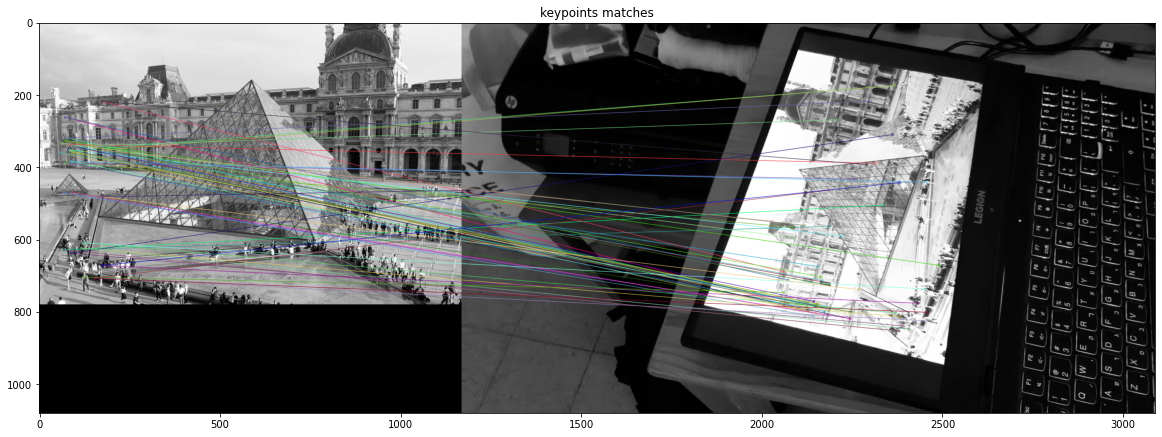

In a second time the pose estimation on frames:


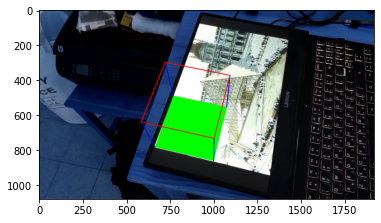

Exercice 2: only if you finished ex1:
extend your code for an 3D object insead of a drwing cube as the video show [here](https://github.com/kinect59/3DET20/blob/master/Data/3Dobject.mp4). you can get the obj file of the 3D object [here](https://github.com/kinect59/3DET20/blob/master/Data/drill.obj)


**For this exercise, I used the chessboard-based pose estimation because the result was visually better than my attempts with homography.**

In [ ]:
!pip install trimesh

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import math

# Camera Matrix and distorsion coefficients
K = np.array([[1.53653164e+03, 0.00000000e+00, 1.04318348e+03],
              [0.00000000e+00, 1.54022929e+03, 5.67584058e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist_coeffs = np.array([0.2897652,  -2.45780323, 0.01189844, 0.02099917, 6.97784126])

# image size in cm
REF_IM_W = 28
REF_IM_H = 19

#Define size of chessboard target. 
chessboard_size = (9,6)

#Define arrays to save detected points
obj_points = [] #3D points in real world space 
img_points = [] #2D points in image plane

#Prepare grid and points to display
objp = np.zeros((np.prod(chessboard_size),3),dtype=np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)

# Define criteria for subpixel accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# ===== video calib input
cap_calib = cv2.VideoCapture('vid_calib.mp4')
fps_calib = np.round(cap_calib.get(cv2.CAP_PROP_FPS))
width = int(np.round(cap_calib.get(cv2.CAP_PROP_FRAME_WIDTH)))
height = int(np.round(cap_calib.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# ===== video input
cap = cv2.VideoCapture('vid.mp4')
fps = np.round(cap.get(cv2.CAP_PROP_FPS))

# ==== video write
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

# ================== Draw a 3D object
def renderObject(img, objectPath, rvecs, tvecs, scaleFactor):
    # Read the object
    mesh = trimesh.load(objectPath)

    # Scale matrix
    scale = np.eye(3) * scaleFactor

    # Rotate -90 degrees (-Pi/2 rad) around X-Axis
    R = trimesh.transformations.rotation_matrix(-math.pi/2,[1,0,0])
    mesh.apply_transform(R)

    # Rotate 90 degrees (Pi/2 rad) around Z-Axis
    R = trimesh.transformations.rotation_matrix(math.pi/2,[0,0,1])
    mesh.apply_transform(R)

    # For each face in the mesh
    for face in mesh.faces:
        vertices = np.array([mesh.vertices[vertexIdx] for vertexIdx in face])
        vertices = np.dot(vertices, scale) # scaling by multiplying with scale matrix

        # Render model in the middle of the reference surface.
        # So, model vertices must be displaced
        vertices = np.array([[v[0] + chessboard_size[0]/2, v[1] + chessboard_size[1]/2, v[2]] for v in vertices])
    
        # Project 3D points (world) to 2D points (frame)
        imgpts = cv2.projectPoints(vertices.reshape(-1,1,3), rvecs, tvecs, K, dist_coeffs)[0]
        imgpts = np.int32(imgpts)

        cv2.fillConvexPoly(img, imgpts, (200,80,80))

    return img

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    h_len = len(hex_color)
    return tuple(int(hex_color[i:i + h_len // 3], 16) for i in range(0, h_len, h_len // 3))

# ========== run on all frames
frame_num = -1
while True:
    # Read Frame
    flag, frame_calib = cap_calib.read()
    flag, frame = cap.read()
    if not flag:
        break

    frame_num += 1
    print("frame num " + str(frame_num))

    frame_calib_rgb = cv2.cvtColor(frame_calib, cv2.COLOR_BGR2RGB)
    frame_calib_gray = cv2.cvtColor(frame_calib, cv2.COLOR_BGR2GRAY)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the video frames
    frames = cv2.hconcat([frame_calib, frame_rgb])
    plt.title("With/Without Chessboard")
    plt.imshow(frames)
    plt.show()

    # Find chessboard corners
    ret,corners = cv2.findChessboardCorners(frame_calib_gray, chessboard_size, None)

    if ret == True:
        # Refine corner location (to subpixel accuracy) based on criteria.
        corners2 = cv2.cornerSubPix(frame_calib_gray, corners, (11,11), (-1,-1), criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, K, dist_coeffs)   
    
        # ======== Draw projection result
        drawn_image = renderObject(frame, 'drill.obj', rvecs, tvecs, 50)

        #drawn_calib = draw(frame_calib, imgpts)
        #plt.title("Frame with chessboard")
        #plt.imshow(drawn_calib)
        #plt.show() 

        # =========== Output
        final_res = cv2.cvtColor(drawn_image, cv2.COLOR_RGB2BGR)
        plt.title("Final Result")
        plt.imshow(final_res)
        plt.show() 
        out.write(final_res)

# ======== end all



Output hidden; open in https://colab.research.google.com to view.